In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters

import blackjax

In [3]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (12, 8)

In [4]:
num_points = 50
X, rows, cols = make_biclusters(
    (num_points, 2), 2, noise=0.6, random_state=314, minval=-3, maxval=3
)
y = rows[0] * 1.0  # y[i] = whether point i belongs to cluster 1

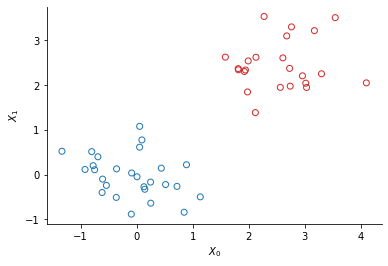

In [5]:
colors = ["tab:red" if el else "tab:blue" for el in rows[0]]
plt.scatter(*X.T, edgecolors=colors, c="none")
plt.xlabel(r"$X_0$")
plt.ylabel(r"$X_1$")
plt.show()

In [7]:
Phi = jnp.c_[jnp.ones(num_points)[:, None], X]
N, M = Phi.shape


def sigmoid(z):
    return jnp.exp(z) / (1 + jnp.exp(z))


def log_sigmoid(z):
    return z - jnp.log(1 + jnp.exp(z))


def logdensity_fn(w, alpha=1.0):
    """The log-probability density function of the posterior distribution of the model."""
    log_an = log_sigmoid(Phi @ w)
    an = Phi @ w
    log_likelihood_term = y * log_an + (1 - y) * jnp.log(1 - sigmoid(an))
    prior_term = alpha * w @ w / 2

    return -prior_term + log_likelihood_term.sum()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [8]:
rng_key = random.PRNGKey(314)

w0 = random.multivariate_normal(rng_key, 0.1 + jnp.zeros(M), jnp.eye(M))

rmh = blackjax.rmh(logdensity_fn, sigma=jnp.ones(M) * 0.7)
initial_state = rmh.init(w0)

In [9]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [10]:
_, rng_key = random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 5_000)

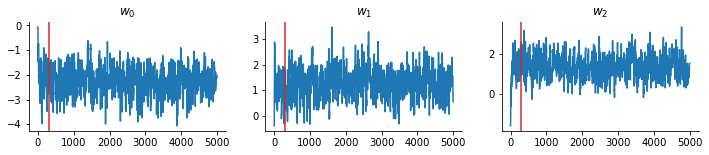

In [11]:
burnin = 300

fig, ax = plt.subplots(1, 3, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.plot(states.position[:, i])
    axi.set_title(f"$w_{i}$")
    axi.axvline(x=burnin, c="tab:red")
plt.show()

In [12]:
burnin = 300
chains = states.position[burnin:, :]
nsamp, _ = chains.shape

In [13]:
# Create a meshgrid
xmin, ymin = X.min(axis=0) - 0.1
xmax, ymax = X.max(axis=0) + 0.1
step = 0.1
Xspace = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
_, nx, ny = Xspace.shape

# Compute the average probability to belong to the first cluster at each point on the meshgrid
Phispace = jnp.concatenate([jnp.ones((1, nx, ny)), Xspace])
Z_mcmc = sigmoid(jnp.einsum("mij,sm->sij", Phispace, chains))
Z_mcmc = Z_mcmc.mean(axis=0)

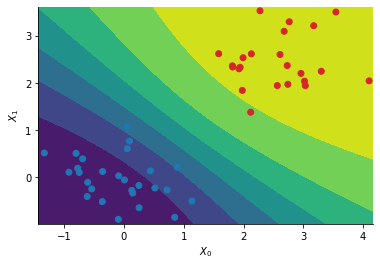

In [15]:
plt.contourf(*Xspace, Z_mcmc)
plt.scatter(*X.T, c=colors)
plt.xlabel(r"$X_0$")
plt.ylabel(r"$X_1$")
plt.show()